## In this notebook I will be reducing the dimensions of the composition based dataset for IL-5 inducing and IL-5 non-inducing peptides using <font color = 'palevioletred'>Principal Component Analysis (PCA) </font> to test whether this would yield better results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from sklearn.metrics import *

import tqdm
import warnings
warnings.filterwarnings('ignore')

# 1. Loading the Data

In [2]:
df = pd.read_csv('../../Data/final_df.csv')
df

,Sequence,Qualitative_Measure,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,...,QSO1_G_R,QSO1_G_S,QSO1_G_T,QSO1_G_V,QSO1_G_W,QSO1_G_Y,QSO1_SC1,QSO1_G1,SOC1_SC1,SOC1_G1
0,DRAHYNIVTFCCKCD,Positive,6.67,20.00,13.33,0.00,6.67,0.00,6.67,6.67,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3610,0.3610,0.4035,17303.9286
1,MHGDTPTLHEYM,Positive,0.00,0.00,8.33,8.33,0.00,8.33,16.67,0.00,...,0.0000,0.0000,0.0003,0.0000,0.0000,0.0001,0.3086,0.3086,0.4057,6560.6364
2,DSTLRLCVQSTHVD,Positive,0.00,7.14,14.29,0.00,0.00,0.00,7.14,0.00,...,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.3301,0.3301,0.3790,12500.1538
3,RNGYRALMDKSLHVGTQCALTRR,Positive,8.70,4.35,4.35,0.00,0.00,8.70,4.35,0.00,...,0.0002,0.0000,0.0001,0.0000,0.0000,0.0000,0.4485,0.4485,0.3696,11510.5000
4,SYVLEGTLTAEKTTLVVKEG,Positive,5.00,0.00,0.00,15.00,0.00,10.00,0.00,0.00,...,0.0000,0.0001,0.0003,0.0002,0.0000,0.0001,0.3506,0.3506,0.2842,6816.4211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11420,AFMGYALPWGQMSFWGATVI,Negative,15.00,0.00,0.00,0.00,10.00,15.00,0.00,5.00,...,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.3390,0.3390,0.2699,12955.8947
11421,QKLAPISIMYQISPPLNVSL,Positive,5.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,...,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.2657,0.2657,0.1904,11019.8421
11422,SCSPTFSSDPLTTPPLMLTT,Negative,0.00,5.00,5.00,0.00,5.00,0.00,0.00,0.00,...,0.0000,0.0003,0.0004,0.0000,0.0000,0.0000,0.2045,0.2045,0.1353,6345.3158
11423,PLPWALQTTNLPLMAMSSLL,Positive,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0000,0.0001,0.0001,0.0000,0.0001,0.0000,0.2224,0.2224,0.1505,9836.7895


In [3]:
X = df.drop(columns=['Sequence', 'Qualitative_Measure'])
y = df['Qualitative_Measure']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9140, 9189), (2285, 9189), (9140,), (2285,))

In [4]:
y_train.value_counts()    # imbalanced dataset

Negative    6941
Positive    2199
Name: Qualitative_Measure, dtype: int64

# Decomposing the feature space using Principal Component Analysis

In [5]:
def decomposition_scorer(X_train, y_train, max_comp, min_comp, model):
    train_scores = []
    val_scores = []
    oversampler = SMOTE(random_state=42)
    scaler = StandardScaler()
    
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train, random_state=42)
    
    X_tr_os, y_tr_os = oversampler.fit_resample(X_tr, y_tr)
    
    val = X_val.copy()  
    val['Qualitative_Measure'] = y_val
    val = val.sample(len(X_tr_os), replace=True)
    
    X_val_os = val.drop(columns='Qualitative_Measure')
    y_val_os = val['Qualitative_Measure']  # keep in mind the val dataset is still imbalanced.
    
    print(X_val_os.shape, X_tr_os.shape)
    
    X_tr_scaled = scaler.fit_transform(X_tr_os)
    X_val_scaled = scaler.transform(X_val_os)
    
    pca = PCA(n_components=max_comp)
    X_train_pca = pd.DataFrame(pca.fit_transform(X_tr_scaled), index = [n for n in range(len(X_tr_scaled))], columns = ['PC'+str(i) for i in range(1,9190)])
    X_val_pca = pd.DataFrame(pca.transform(X_val_scaled), index = [n for n in range(len(X_val_scaled))], columns = ['PC'+str(j) for j in range(1,9190)])
    
    for i in tqdm.tqdm((range(max_comp, min_comp, -150))):
        X_tr = X_train_pca.iloc[:, :i]
        y_tr = y_tr_os
        X_vl = X_val_pca.iloc[:, :i]
        y_vl = y_val_os
        
        model.fit(X_tr, y_tr)
        train_scores.append(matthews_corrcoef(y_tr, model.predict(X_tr)))
        val_scores.append(matthews_corrcoef(y_vl, model.predict(X_vl)))
                       
    return train_scores, val_scores   

In [6]:
logreg = LogisticRegression()

train_scores, val_scores = decomposition_scorer(X_train, y_train, 9189, 200, logreg)

(11106, 9189) (11106, 9189)


100%|███████████████████████████████████████████| 60/60 [03:04<00:00,  3.08s/it]


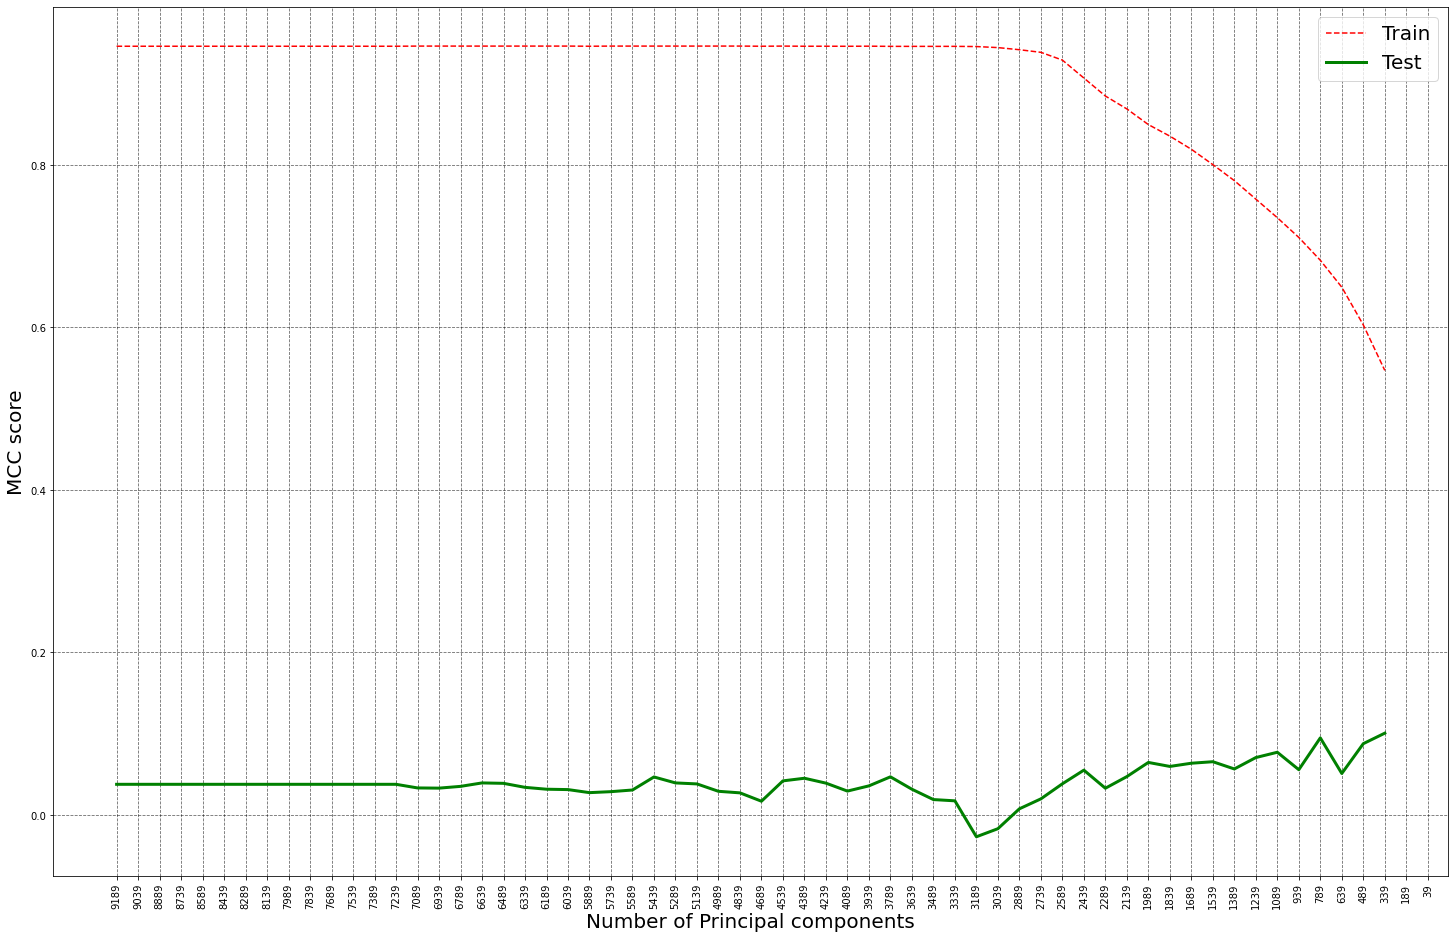

In [7]:
plt.figure(figsize=(25, 16))
plt.plot(train_scores, label='Train', color='r', linewidth=1.5, linestyle='--')
plt.plot(val_scores, label ='Test' , color='g', linewidth=3)
plt.xticks(ticks = range(62), labels = range(9189,2,-150), rotation=90)
plt.ylabel('MCC score', fontsize=20)
plt.xlabel('Number of Principal components', fontsize=20)
plt.grid(alpha=0.6, color='k', linestyle='--')
plt.legend(fontsize=20)

I will be choosing to build a model using 3189 Principal components since beyond this point the MCC score on the training data starts falling which means the data might have started to lose variance/information.

In [7]:
1

1

In [8]:
# we will start by having a look at our data again
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9140, 9189), (2285, 9189), (9140,), (2285,))

In [9]:
y_train.value_counts()   # imbalanced dataset

Negative    6941
Positive    2199
Name: Qualitative_Measure, dtype: int64

In [10]:
# Oversampling the training dataset to get rid of the imbalance
oversampler = SMOTE(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [11]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# performing PCA
# we will calculate only the decided number of PCs

pca = PCA(n_components=3639)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [13]:
# tranforming into dataframe
X_train_pca_df = pd.DataFrame(X_train_pca, index=X_train.index, columns = ['PC'+str(i) for i in range(1,3640)])
X_test_pca_df = pd.DataFrame(X_test_pca, index=X_test.index, columns = ['PC'+str(i) for i in range(1,3640)])

In [14]:
X_train_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC3630,PC3631,PC3632,PC3633,PC3634,PC3635,PC3636,PC3637,PC3638,PC3639
0,3.457726,-0.847575,-7.220624,-4.488641,-4.971660,5.005441,-0.896669,-4.996570,0.665602,-1.864864,...,-0.515671,0.938233,-0.440141,-1.993681,-0.444664,-0.048323,0.769500,0.282352,0.521374,0.562237
1,-4.946832,3.874969,-7.329489,-7.609562,14.843782,-6.117322,-0.607875,-5.708384,-10.868809,-1.640369,...,-0.443294,0.822739,0.316052,-1.879649,-0.309034,2.670331,-0.058416,-1.011827,-2.198367,-1.329059
2,-14.778462,-1.818154,-5.056355,5.969693,-6.940779,-2.958129,0.877761,5.689620,0.878214,-3.266820,...,0.097331,-0.119252,-0.226345,-0.246763,-0.027090,-0.657197,0.215199,-0.072231,-0.224182,0.657558
3,-1.992042,1.599857,-16.087872,-8.035544,-3.058636,0.847603,-1.749190,-5.388846,5.834720,-1.316906,...,0.479484,-0.075166,-0.189869,-0.224953,0.787760,0.468315,0.164483,-0.307141,0.421489,0.430046
4,-5.150343,2.264311,-8.341953,-0.864153,-4.454338,-4.797145,-2.267338,3.524004,-3.104450,-0.632308,...,-0.271206,0.131677,-0.333494,0.054948,-0.092919,-0.529377,0.254762,0.043089,0.449823,0.437704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13877,10.440978,0.546360,-2.628275,2.644376,0.586671,2.722648,-1.956023,6.276811,-0.944683,-3.830460,...,0.019114,0.367363,-0.192220,-0.391937,0.051928,0.064119,0.151933,-0.280018,0.970193,0.507173
13878,12.092293,-2.259541,-2.190965,2.509047,3.504866,0.876500,1.204014,0.476018,-5.883437,-4.538283,...,-0.230605,0.124354,-0.361809,-0.393236,-0.412716,0.072059,-0.270586,-0.148183,0.012382,-0.453655
13879,8.338360,0.771803,4.815452,-3.070778,-0.210341,-1.122896,2.934702,9.114265,-3.687025,-1.829178,...,0.099749,-0.102971,-0.084153,0.232894,0.053540,-0.063790,0.620325,0.052912,-0.099911,0.153622
13880,9.542740,-4.985157,-6.567761,-1.587885,2.790448,3.063131,1.250074,-4.206811,-1.439962,-7.276229,...,0.164284,0.215964,-0.743836,0.459196,0.027291,0.155265,-0.303352,-0.555746,-0.423791,-0.228884


In [15]:
X_test_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC3630,PC3631,PC3632,PC3633,PC3634,PC3635,PC3636,PC3637,PC3638,PC3639
9477,-6.721558,8.646255,-2.944083,-5.688962,-0.907781,-0.154317,-5.327757,0.795542,-1.496048,-3.292352,...,-0.196119,0.578482,1.347707,0.540703,-0.540813,1.136799,0.740676,-0.443197,-1.557319,-0.706316
5286,3.654245,5.330777,-1.357544,-5.591153,1.883270,0.083794,-1.796865,-2.618282,-4.008723,-3.618295,...,0.611748,-0.005333,0.507011,0.817493,-0.975130,-0.747589,-0.242965,-1.359498,0.660094,-0.113254
4722,1.581873,-13.850157,9.323437,-4.650711,2.742452,-3.041030,-3.546946,3.922219,5.385413,-0.232859,...,-0.422762,2.042325,0.357262,0.054173,-0.465727,2.041930,-1.611877,0.840897,0.081984,1.831302
4331,-19.765827,-11.346185,-15.742651,-1.023386,-1.100295,8.570026,1.962064,-6.810424,2.848634,1.013514,...,-1.379698,-1.039313,-1.078947,1.157224,0.316141,-0.229955,-0.776811,-0.165768,-1.429835,-0.173491
6174,5.289228,-5.511334,-7.182461,-4.783512,-1.114992,-2.304514,-2.982579,-3.033530,2.846461,1.923975,...,0.031932,-0.047791,-0.622475,1.234188,-0.970628,0.785441,0.255713,-0.942188,-0.344783,-1.201496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6304,18.765531,-3.588282,-4.254011,-7.593009,-5.730760,1.170310,0.393610,10.353078,-3.769953,-7.055517,...,-1.332242,0.515200,0.880027,-0.318791,0.637665,0.069821,-0.385085,-1.373504,0.152589,0.206218
7556,1.436436,3.709944,19.614677,1.274043,-0.937170,4.363413,-7.347429,-8.263595,-1.557731,7.022329,...,-0.645687,0.866900,0.062338,-0.042934,-1.862975,2.559356,-1.446049,-1.778165,0.480769,-3.980929
6602,-5.478762,-6.678110,0.176533,1.345961,-5.542620,3.143540,3.363644,7.795953,2.800134,-7.899042,...,-0.608677,1.073894,-1.062927,1.267324,-0.815093,-1.515350,0.708231,-0.014717,0.045869,-0.048817
203,6.591301,-2.836646,0.914778,-3.285818,-2.419551,4.248076,10.535879,7.112769,0.972704,-7.675837,...,-0.155736,0.054950,-1.262422,-0.978115,-0.132545,0.377842,-1.477868,-2.118223,1.600864,-0.762610


# Building models
## 1. LogisticRegression

In [18]:
# we will make our own scorer function to use in grid search cv
def matthews_correlation(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    mcc = (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
    
    return mcc

mcc = make_scorer(matthews_correlation, greater_is_better=True)

In [27]:
param_grid_lr = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]}

logreg = LogisticRegression(max_iter=1000)

stratified_fold = StratifiedKFold()

gridlr = GridSearchCV(logreg, param_grid_lr, cv = stratified_fold, n_jobs=-1, scoring=mcc, return_train_score=True)

gridlr.fit(X_train_pca_df, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7,
                               1]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [28]:
pd.DataFrame(gridlr.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
1,{'C': 0.0001},0.799915,0.663043
2,{'C': 0.001},0.862487,0.643866
3,{'C': 0.01},0.908474,0.579219
0,{'C': 1e-05},0.687003,0.576103
4,{'C': 0.1},0.936387,0.537243
5,{'C': 0.3},0.941714,0.524930
6,{'C': 0.5},0.942943,0.522235
7,{'C': 0.7},0.943415,0.520261
8,{'C': 1},0.943695,0.517846


In [29]:
modellr = gridlr.best_estimator_

### Evaluating the model performance

In [31]:
# have to change the values from Negative and Positives to 1s and 0s to 
# Make sure that the predictions provided by the classifier (0,1) coincides with these true labels
y_train_mapped = y_train.map({'Negative':0, 'Positive':1})
y_train_mapped

0        0
1        0
2        1
3        0
4        0
        ..
13877    1
13878    1
13879    1
13880    1
13881    1
Name: Qualitative_Measure, Length: 13882, dtype: int64

In [32]:
y_test_mapped = y_test.map({"Negative":0, "Positive":1})
y_test_mapped

9477    1
5286    0
4722    0
4331    0
6174    0
       ..
6304    1
7556    0
6602    0
203     1
5979    0
Name: Qualitative_Measure, Length: 2285, dtype: int64

In [33]:
# function to calculate various performance metrics on both training and testing datasets for all thresholds
def metrics_df(model, X_train, X_test, y_train, y_test):
    threshold_list = np.arange(0,1.05,0.05)
    metrics = []
    for i in threshold_list:
        y_preds_tr = (model.predict_proba(X_train)[:,1] > i).astype("float")
        y_preds_ts = (model.predict_proba(X_test)[:,1] > i).astype("float")
        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train_mapped, y_preds_tr).ravel()
        tn_ts, fp_ts, fn_ts, tp_ts = confusion_matrix(y_test_mapped, y_preds_ts).ravel()
        sens_tr = recall_score(y_train_mapped, y_preds_tr)
        sens_ts = recall_score(y_test_mapped, y_preds_ts)
        spec_tr = tn_tr / (tn_tr + fp_tr)
        spec_ts = tn_ts / (tn_ts + fp_ts)
        acc_tr = accuracy_score(y_train_mapped, y_preds_tr)
        acc_ts = accuracy_score(y_test_mapped, y_preds_ts)
        prec_tr = precision_score(y_train_mapped, y_preds_tr)
        prec_ts = precision_score(y_test_mapped, y_preds_ts)
        npv_tr = tn_tr / (tn_tr + fn_tr)
        npv_ts = tn_ts / (tn_ts + fn_ts)
        mcc_tr = matthews_corrcoef(y_train_mapped, y_preds_tr)
        mcc_ts = matthews_corrcoef(y_test_mapped, y_preds_ts)
        metrics.append([sens_tr,sens_ts,spec_tr,spec_ts,acc_tr,acc_ts,prec_tr,prec_ts,npv_tr,npv_ts,mcc_tr,mcc_ts])
    model_metrics = pd.DataFrame(metrics, index=threshold_list, columns= ['Sens/Recall_train','Sens/Recall_test', 
                                                                       'Spec_train', 'Spec_test', 
                                                                       'Accuracy_train','Accuracy_test',
                                                                       'precision/PPV_train', 'precision/PPV_test',
                                                                       'npv_train','npv_test',
                                                                       'mcc_train','mcc_test'])
    model_metrics.index.name = 'Threshold'
    return model_metrics

The AUC-PRC is 0.3262839715908502


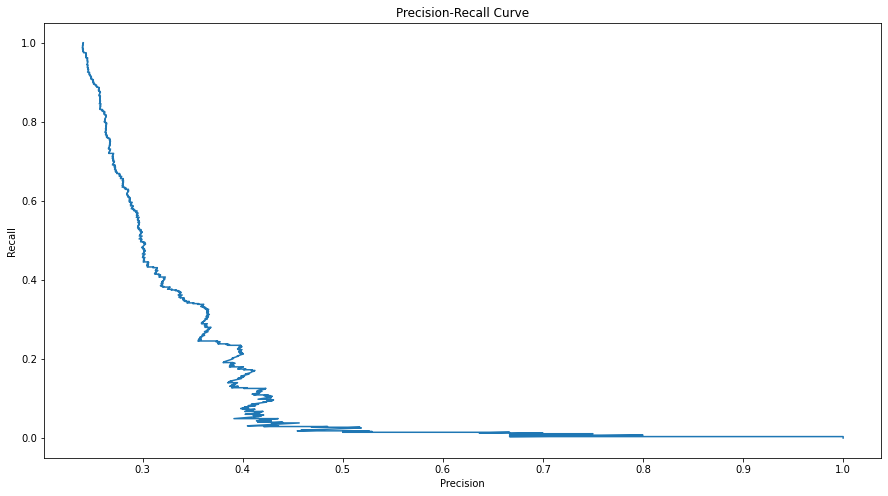

In [37]:
# AU-PRC 
precision, recall, threshold = precision_recall_curve(y_test, modellr.decision_function(X_test_pca_df), pos_label='Positive')

plt.figure(figsize=(15,8))
plt.plot(precision, recall, label = 'precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')

print(f"The AUC-PRC is {average_precision_score(y_test, modellr.decision_function(X_test_pca_df), pos_label='Positive')}")

The AU-ROC is 0.5925575058946817


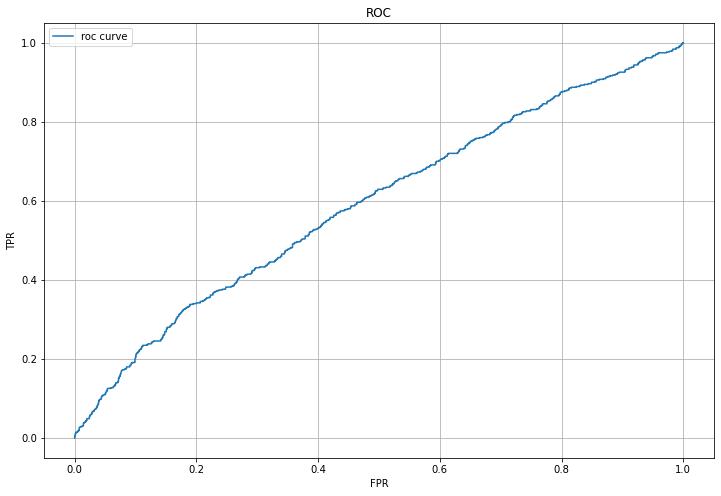

In [38]:
# AU-ROC
fpr, tpr, thresholds = roc_curve(y_test, modellr.predict_proba(X_test_pca_df)[:,1], pos_label='Positive')

plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label = 'roc curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')

plt.legend()
plt.grid()

print(f"The AU-ROC is {roc_auc_score(y_test, modellr.predict_proba(X_test_pca_df)[:,1])}")

An almost straight line tells us that the LogisticRegression model is mostly making random predictions.

In [35]:
metrics_df(modellr, X_train_pca_df, X_test_pca_df, y_train_mapped, y_test_mapped)

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.240700,0.500000,0.240700,NaN,NaN,0.000000,0.000000
0.05,1.000000,1.000000,0.000432,0.000576,0.500216,0.241138,0.500108,0.240806,1.000000,1.000000,0.014702,0.011781
0.10,0.999712,0.987273,0.010661,0.010375,0.505187,0.245514,0.502608,0.240265,0.973684,0.720000,0.070290,-0.009669
0.15,0.999280,0.961818,0.060798,0.055331,0.530039,0.273523,0.515496,0.244004,0.988290,0.820513,0.173972,0.033263
0.20,0.997263,0.905455,0.179081,0.142363,0.588172,0.326039,0.548494,0.250755,0.984945,0.826087,0.306706,0.060617
0.25,0.993373,0.820000,0.345339,0.266282,0.669356,0.399562,0.602762,0.261601,0.981171,0.823529,0.444730,0.085704
0.30,0.984008,0.705455,0.519089,0.397118,0.751549,0.471335,0.671715,0.270572,0.970113,0.809636,0.568245,0.090703
0.35,0.972050,0.594545,0.660712,0.536023,0.816381,0.550109,0.741266,0.288869,0.959414,0.806592,0.665855,0.111643
0.40,0.951304,0.465455,0.777266,0.655331,0.864285,0.609628,0.810283,0.299766,0.941043,0.794549,0.739860,0.106733


We get the best performance (MCC=0.133) of LogisticRegression at the deafult threshold of 0.50, however this is lower as compared to the performance of LogisticRegression on the feature dropped dataset.

## 2. LightGBM
### 2.1 With default parameters

In [40]:
lgb = LGBMClassifier(objective='binary')

lgb.fit(X_train_pca_df, y_train)

LGBMClassifier(objective='binary')

The AUC-PRC is 0.2620410189295165


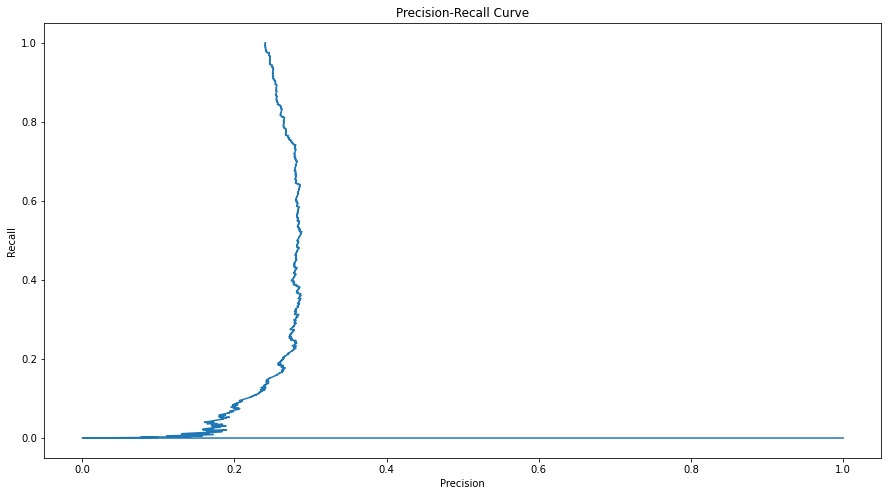

In [42]:
# AU-PRC 
precision, recall, threshold = precision_recall_curve(y_test, lgb.predict_proba(X_test_pca_df)[:,1], pos_label='Positive')

plt.figure(figsize=(15,8))
plt.plot(precision, recall, label = 'precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')

print(f"The AUC-PRC is {average_precision_score(y_test, lgb.predict_proba(X_test_pca_df)[:,1], pos_label='Positive')}")

The AU-ROC is 0.5644438040345822


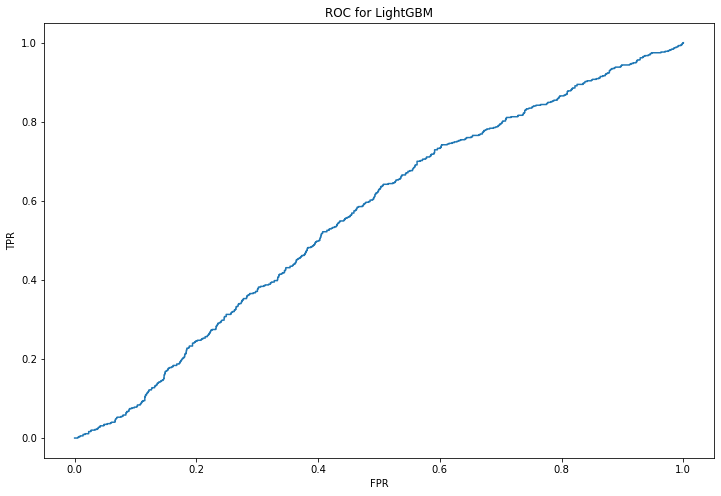

In [43]:
# AU-ROC
fpr, tpr, threshold = roc_curve(y_test, lgb.predict_proba(X_test_pca_df)[:,1], pos_label="Positive")

plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label = 'ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for LightGBM')

print(f"The AU-ROC is {roc_auc_score(y_test, lgb.predict_proba(X_test_pca_df)[:,1])}")

Even LightGBM is making random predictions

In [44]:
lgb_metrics = metrics_df(lgb, X_train_pca_df, X_test_pca_df, y_train_mapped, y_test_mapped)
lgb_metrics

,Sens/Recall_train,Sens/Recall_test,Spec_train,Spec_test,Accuracy_train,Accuracy_test,precision/PPV_train,precision/PPV_test,npv_train,npv_test,mcc_train,mcc_test
Threshold,,,,,,,,,,,,
0.00,1.000000,1.000000,0.000000,0.000000,0.500000,0.240700,0.500000,0.240700,NaN,NaN,0.000000,0.000000
0.05,1.000000,0.589091,0.521251,0.525648,0.760625,0.540919,0.676247,0.282476,1.000000,0.801406,0.593712,0.098105
0.10,1.000000,0.360000,0.777410,0.716427,0.888705,0.630635,0.817935,0.286957,1.000000,0.779310,0.797415,0.071166
0.15,1.000000,0.247273,0.860395,0.797118,0.930197,0.664770,0.877497,0.278689,1.000000,0.769616,0.868904,0.046306
0.20,1.000000,0.183636,0.891658,0.832277,0.945829,0.676149,0.902249,0.257653,1.000000,0.762810,0.896938,0.018045
0.25,1.000000,0.152727,0.906930,0.853026,0.953465,0.684464,0.914854,0.247788,1.000000,0.760534,0.910883,0.006919
0.30,1.000000,0.127273,0.915142,0.872046,0.957571,0.692779,0.921780,0.239726,1.000000,0.759157,0.918455,-0.000872
0.35,0.998991,0.103636,0.920617,0.884726,0.959804,0.696718,0.926386,0.221790,0.998906,0.756903,0.922446,-0.015747
0.40,0.997407,0.085455,0.925227,0.891643,0.961317,0.697593,0.930261,0.200000,0.997205,0.754634,0.925046,-0.032234


The best testing score of MCC (still extremely low at 0.09) is at the meagre prediction threshold of 0.05.

I couldn't try the rest of the models since a high memory consumption kept killing the kernel.

### <font color = 'palevioletred'>CONCLUSION:</font>
We can see from the models that we did manage to fit; **LogisticRegression, LightGBM(default parameter)** that the performance on even the PCA reduced dataset is very poor, so doesnt matter if we drop features based on their importance using RFE, or use PCA to work with dimensions containing the maximum variance, the models are still performing poorly which again reflects on the lack of distinguishing signal in the composition based features for the IL-5 inducing and non-inducing peptides.

### Since the composition based features did not work, we can try to look at the sequential information contained within the peptides themselves by using Natural Language Processing (NLP)